In [1]:
import sys
sys.path.append('../.')

from utils import *
from Data.DataGenerator import *
from Models.Models_normal import *
from Training.Spike_loss import *
import torch.optim as optim
from Training.Analysis import fixed_model_batch_analysis
from Data.DataLoader import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering, BisectingKMeans
from sklearn.linear_model import RANSACRegressor
from tqdm import tqdm
import numpy as np
import itertools
from sklearn.linear_model import RANSACRegressor

import torch

In [4]:
# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
arch = (784, [100 for _ in range(62)] + [10])

# model = MNIST_classifier(n_in=arch[0], layer_list=arch[1], bias=1e-4)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 32, 16, 8, 3], bias=0)
# # model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)

# state_dict = torch.load('/home/mila/m/mehrab.hamidi/scratch/training_res/november_res/mnist/normal/bias_0.0001/mnist_training/try_num2/epoch_100/model.pt', weights_only=False)
# arch = (784, [256, 128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10])


state_dict = torch.load('/home/mila/m/mehrab.hamidi/scratch/training_res/november_res/mnist/normal/bias_0.0001/mnist_training/try_num2/epoch_120/model.pt', weights_only=False)

# arch = (784, [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10])
model = MNIST_classifier(n_in=arch[0], layer_list=arch[1], bias=0)

# state_dict = torch.load('/home/mila/m/mehrab.hamidi/scratch/training_res/january_res_png/mnist/constant_width/bias_0.0001/mnist_training/try_num3/epoch_100/model.pt', weights_only=False)
# model.load_state_dict(state_dict)

model.eval()


# load the data
_, _, _, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_mnist_data_loaders()



dataset_target_samples = train_samples
dataset_target_labels = train_labels

Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Train Samples Shape: torch.Size([50000, 784])
Train Labels Shape: torch.Size([50000])

Validation Samples Shape: torch.Size([10000, 784])
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: torch.Size([10000, 784])
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})
Validation Label Frequencies: Counter({7: 1090, 1: 1064, 3: 1030, 8: 1009, 0: 991, 2: 990, 4: 983, 6: 967, 9: 961, 5: 915})
Test Label Frequencies: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


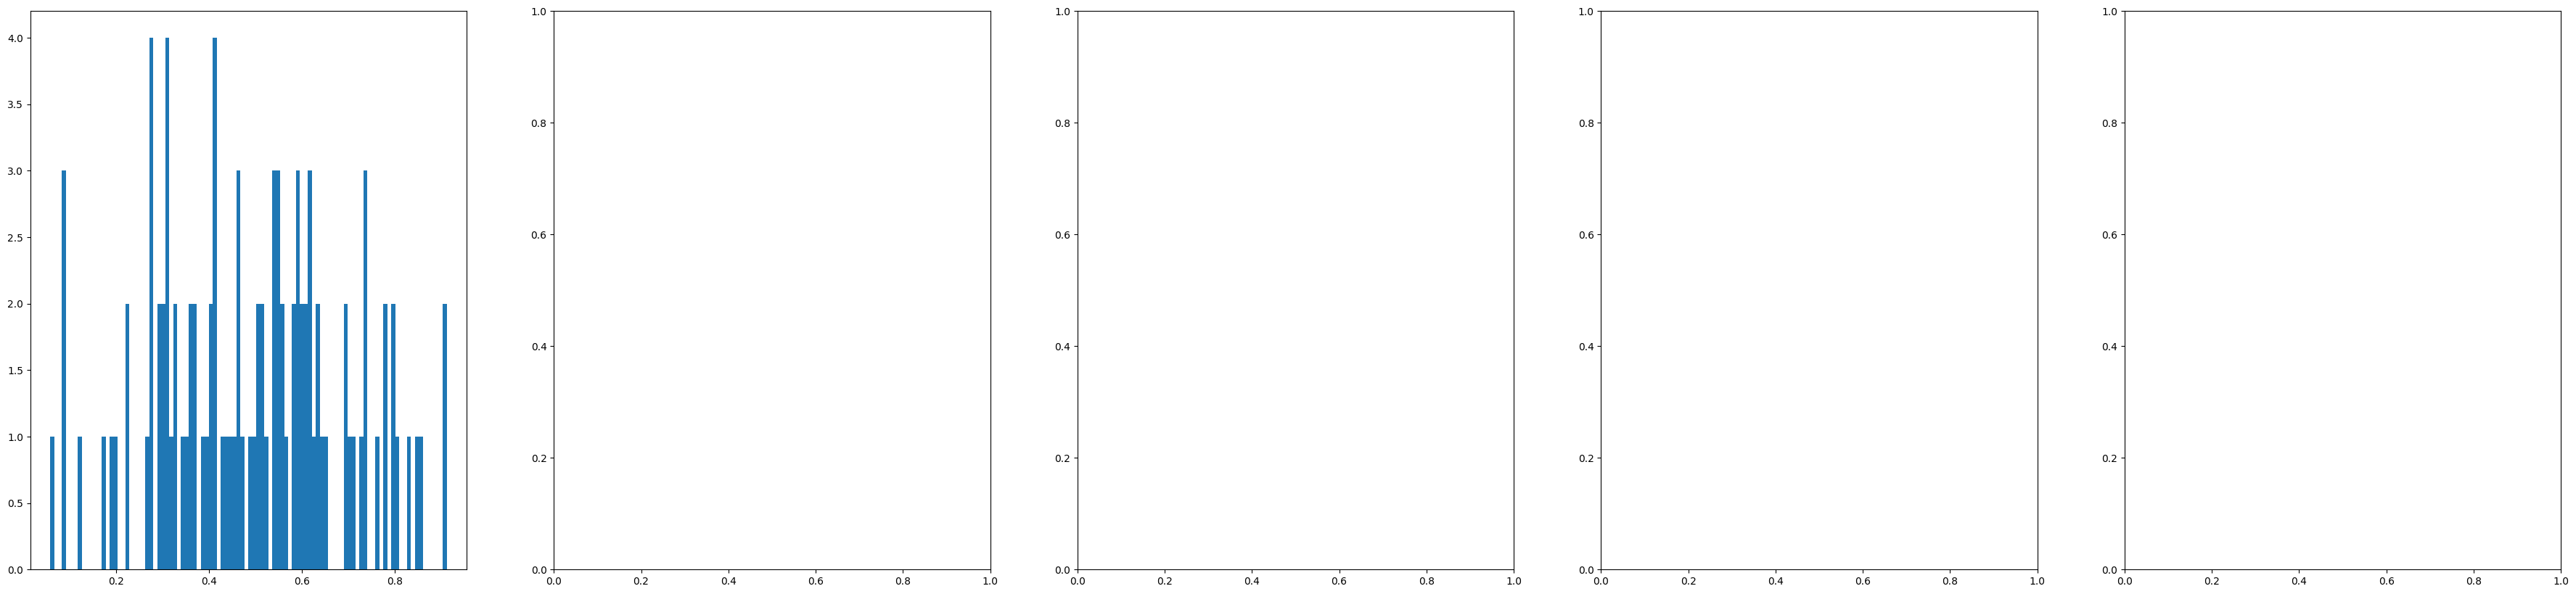

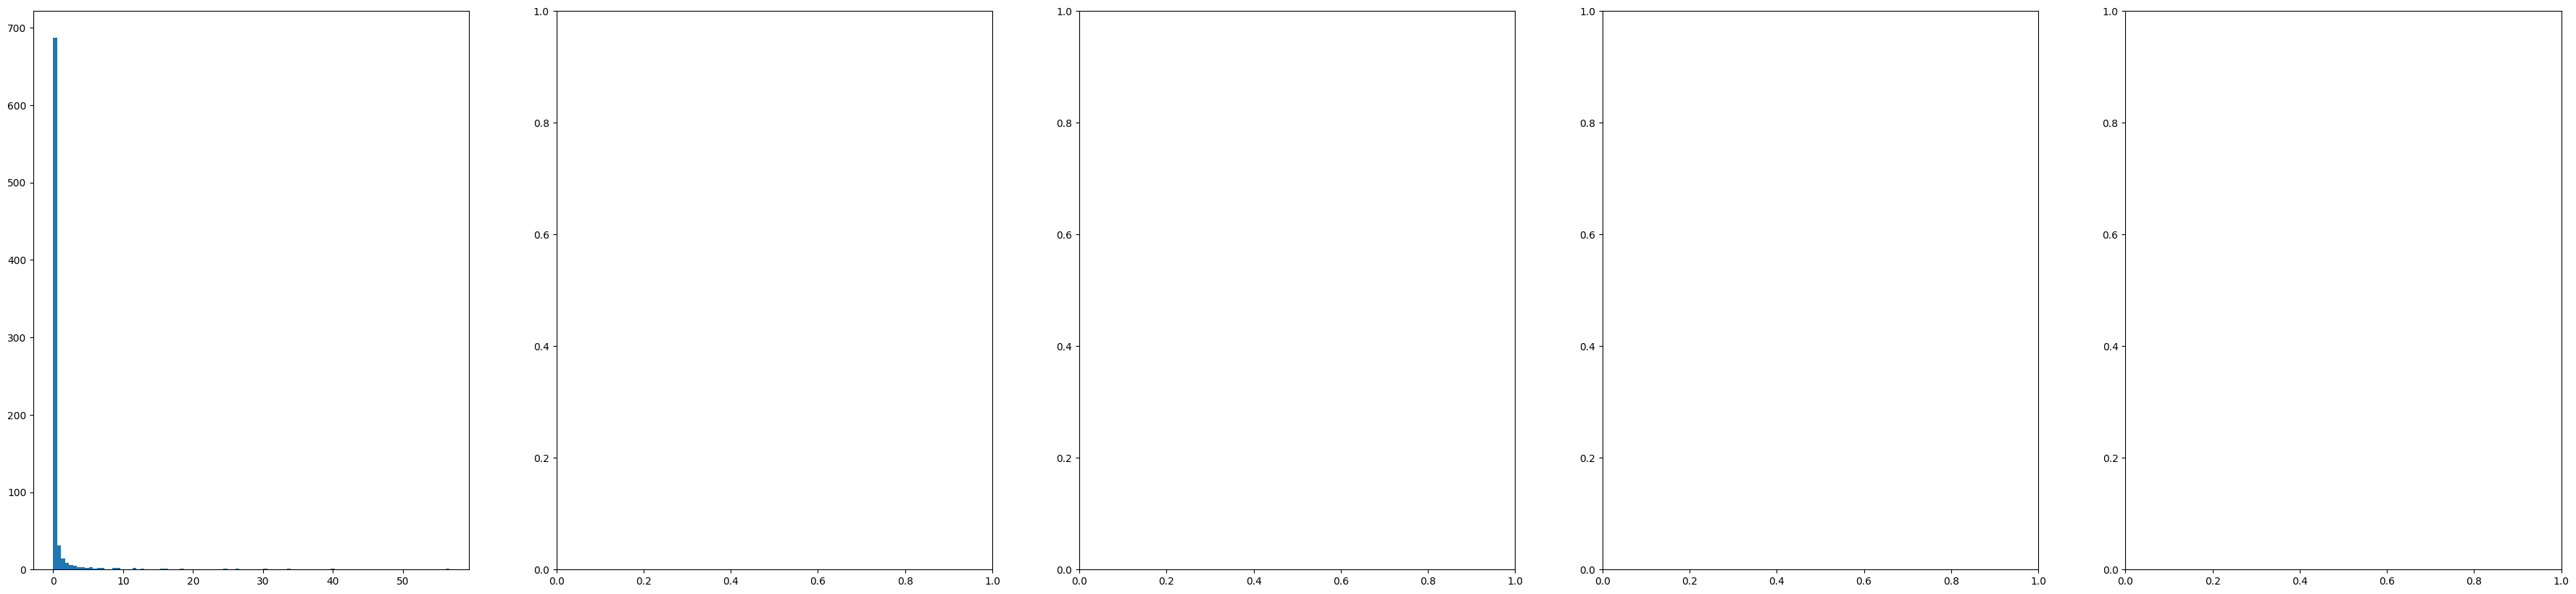

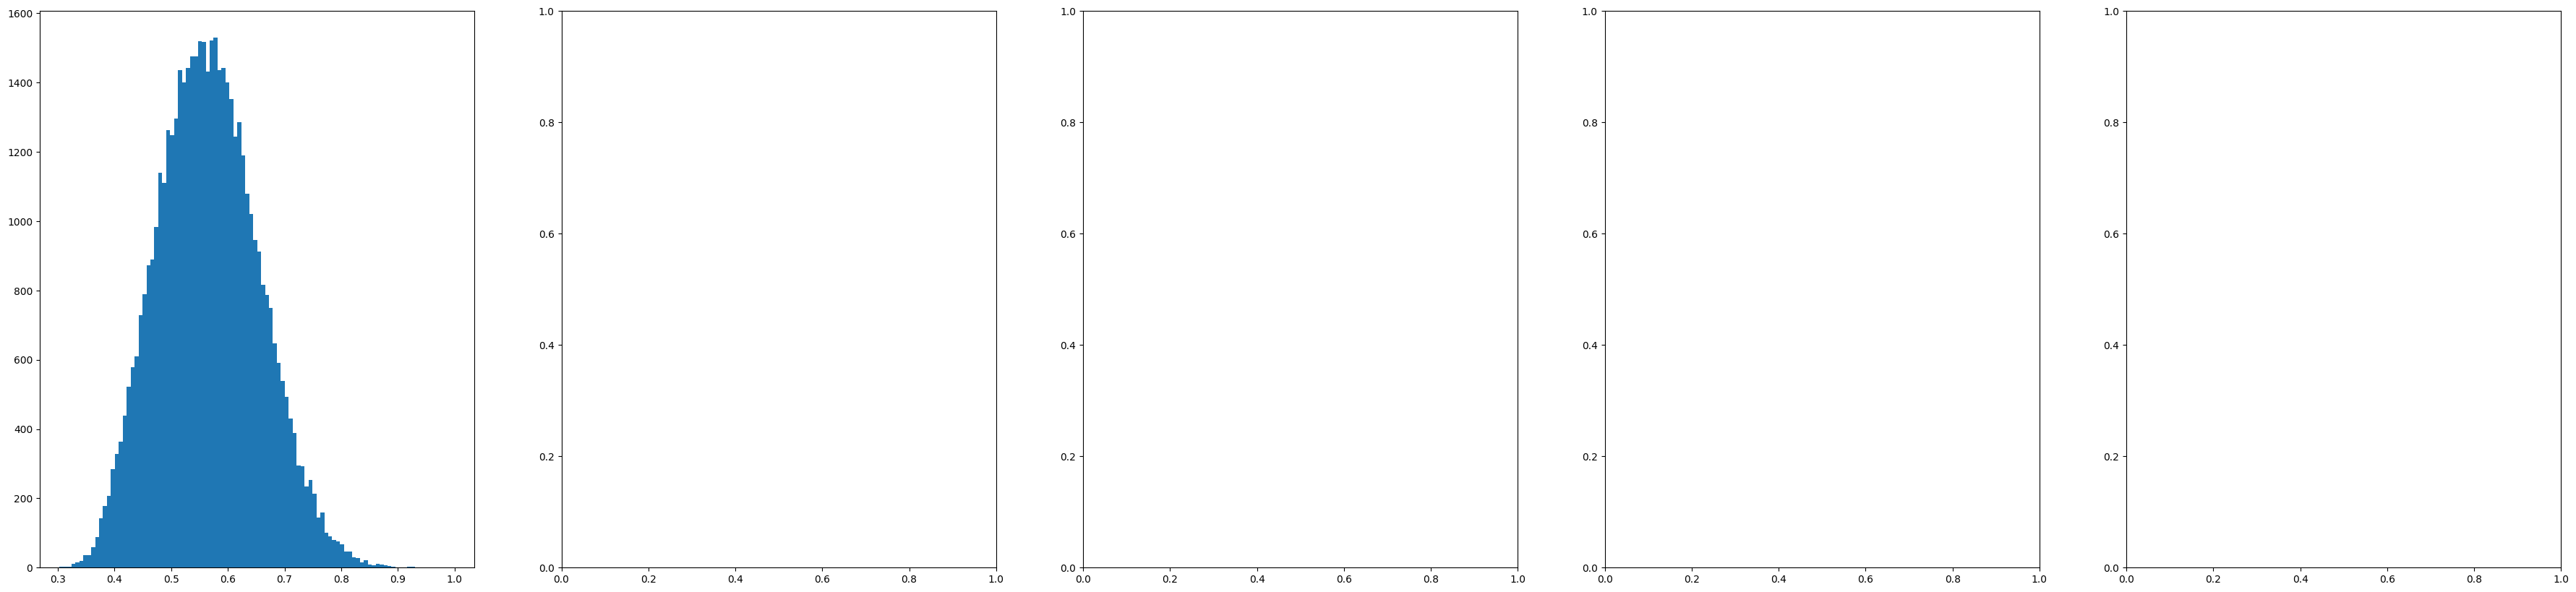

---


In [5]:
anal_path = '../../spike_analysis/plots_untrained_2/'
if not os.path.isdir(anal_path):
    os.makedirs(anal_path)
results_dict = fixed_model_batch_analysis(model, dataset_target_samples, dataset_target_labels, device, '{}_{}'.format(anal_path, 'val_'), 'analyze', plotting=True, no_custome_range='input')
plt.close()
print("---")

In [30]:
def _hyperplane_distance(coef1, intercept1, coef2, intercept2):
    # Calculate the angle between the normal vectors of the hyperplanes
    cos_angle = np.dot(coef1, coef2) / (np.linalg.norm(coef1) * np.linalg.norm(coef2))
    angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))

    # Calculate the distance between the hyperplanes at the origin
    d = np.abs(intercept1 - intercept2) / np.linalg.norm(coef1)

    return angle, d

def spike_detection_2d_lines(points, max_lines=30, min_points_for_line=100, residual_threshold=0.5, merge_threshold=0.01):
    merge_threshold = merge_threshold * (points.shape[1] - 1)
    residual_threshold *= (points.shape[1] - 1)

    def fit_line_ransac(points):
        # Randomly select two dimensions for fitting the line
        n_dims = points.shape[1]
        dim_indices = np.random.choice(n_dims, 2, replace=False)

        X = points[:, dim_indices[0]].reshape(-1, 1)  # Use one dimension as X
        y = points[:, dim_indices[1]]  # Use the other dimension as Y

        # Fit a line using RANSAC
        ransac = RANSACRegressor(LinearRegression(), 
                                 max_trials=1000, 
                                 min_samples=2,
                                 residual_threshold=residual_threshold,
                                 stop_probability=0.99)
        ransac.fit(X, y)
        return ransac, dim_indices

    def get_line_eq(ransac, dim_indices, n_dims):
        coef = ransac.estimator_.coef_[0]
        intercept = ransac.estimator_.intercept_

        # Set up the equation for the line in the n-dimensional space
        full_coef = np.zeros(n_dims)
        full_coef[dim_indices[0]] = coef
        full_coef[dim_indices[1]] = -1

        return full_coef, intercept

    def point_to_line_distance(point, coef, intercept):
        return np.abs(np.dot(coef, point) + intercept) / np.linalg.norm(coef)

    n_dims = points.shape[1]
    lines = []
    remaining_points = points.copy()
    assigned_points = []
    total_error = 0

    for _ in range(max_lines):
        if len(remaining_points) < min_points_for_line:
            break

        try:
            ransac, dim_indices = fit_line_ransac(remaining_points)
        except:
            return [], 0, []

        coef, intercept = get_line_eq(ransac, dim_indices, n_dims)
        
        inlier_mask = ransac.inlier_mask_
        inlier_points = remaining_points[inlier_mask]
        
        line_error = sum(point_to_line_distance(p, coef, intercept) for p in inlier_points)
        total_error += line_error
        
        lines.append((coef, intercept, len(inlier_points), line_error))
        assigned_points.append(inlier_points)
        
        remaining_points = remaining_points[~inlier_mask]
    
    if len(lines) == 0:
        return [], 0, []

    # Assign remaining points to the nearest line
    for point in remaining_points:
        distances = [point_to_line_distance(point, coef, intercept) for coef, intercept, _, _ in lines]
        nearest_line_index = np.argmin(distances)
        total_error += distances[nearest_line_index]
        assigned_points[nearest_line_index] = np.vstack([assigned_points[nearest_line_index], point])

    # Merge close lines
    i = 0
    while i < len(lines):
        j = i + 1
        while j < len(lines):
            angle, dist = _hyperplane_distance(lines[i][0], lines[i][1], lines[j][0], lines[j][1])
            if angle < merge_threshold:
                # Merge lines
                new_coef = (lines[i][0] + lines[j][0]) / 2
                new_intercept = (lines[i][1] + lines[j][1]) / 2
                new_inliers = lines[i][2] + lines[j][2]
                new_error = lines[i][3] + lines[j][3]
                new_points = np.vstack([assigned_points[i], assigned_points[j]])

                lines[i] = (new_coef, new_intercept, new_inliers, new_error)
                assigned_points[i] = new_points

                # Remove the merged line
                del lines[j]
                del assigned_points[j]
            else:
                j += 1
        i += 1

    # Sort lines by number of inliers (descending)
    lines = sorted(zip(lines, assigned_points), key=lambda x: x[0][2], reverse=True)
    lines, assigned_points = zip(*lines)

    return lines, total_error, assigned_points

In [31]:
# data = results_dict['representations'][11]

data = np.array(results_dict['pca_2'][6]).transpose()
data = torch.Tensor(data)

mnist_labels = dataset_target_labels.detach().cpu().numpy()
mnist_data = dataset_target_samples.detach().cpu().numpy().reshape(dataset_target_samples.shape[0], 28 * 28)

class_data_indices = np.where(mnist_labels == 1)[0]
class_data = data[class_data_indices]



points = class_data.clone().detach().cpu().numpy()
# Detect hyperplanes
detected_hyperplanes, total_error, assigned_points = spike_detection_nd(points)

# Print results
print(f"Total error: {total_error:.4f}")
for i, (coef, intercept, num_inliers, hyperplane_error) in enumerate(detected_hyperplanes):
    print(f"Hyperplane {i+1}:")
    print(f"Equation: {' + '.join([f'{c:.4f}x{j+1}' for j, c in enumerate(coef)])} + {intercept:.4f} = 0")
    print(f"Number of inliers: {num_inliers}")
    print(f"Hyperplane error: {hyperplane_error:.4f}")


Total error: 726.9080
Hyperplane 1:
Equation: 2.4007x1 + -1.0000x2 + 0.1444 = 0
Number of inliers: 2222
Hyperplane error: 103.1704
Hyperplane 2:
Equation: -1.0000x1 + 0.3903x2 + -0.0106 = 0
Number of inliers: 1138
Hyperplane error: 72.2930
Hyperplane 3:
Equation: 2.3120x1 + -1.0000x2 + 0.0748 = 0
Number of inliers: 1115
Hyperplane error: 34.7944
Hyperplane 4:
Equation: 2.6086x1 + -1.0000x2 + 0.4587 = 0
Number of inliers: 1094
Hyperplane error: 49.4718
Hyperplane 5:
Equation: -1.0000x1 + 0.4164x2 + -1.0923 = 0
Number of inliers: 20
Hyperplane error: 2.9316


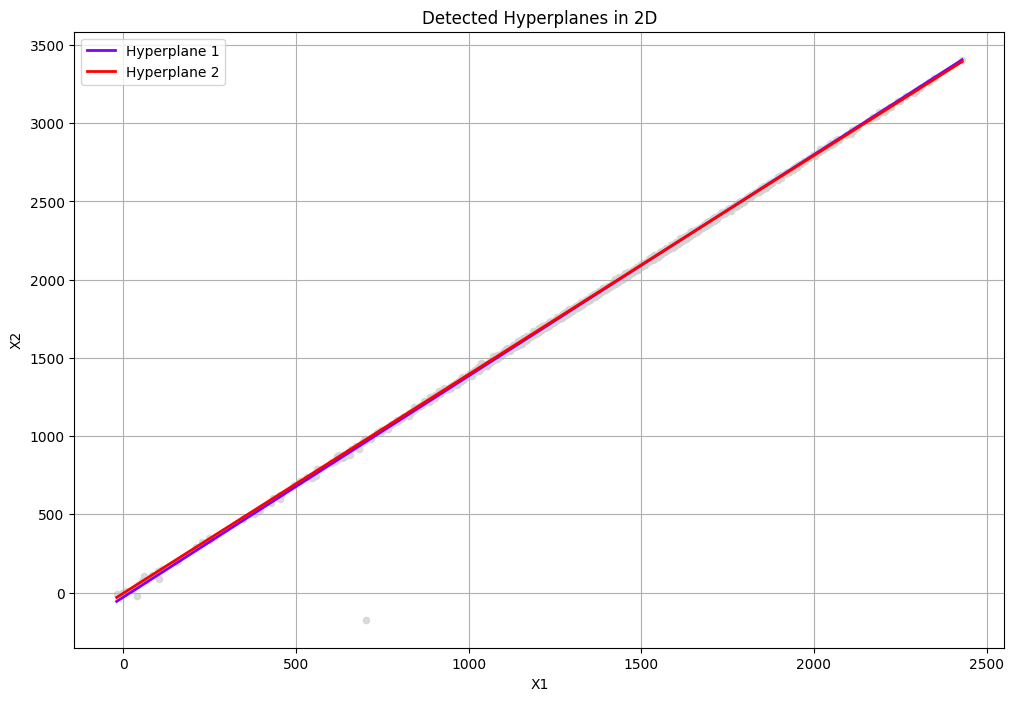

929.1333163601402


In [11]:
plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(detected_hyperplanes)))

# Plot all points
plt.scatter(points[:, 0], points[:, 1], c='lightgray', s=20, alpha=0.8)

# Plot assigned points and hyperplanes
for (coef, intercept, _, _), assigned, color in zip(detected_hyperplanes, assigned_points, colors):
    # plt.scatter(assigned[:, 0], assigned[:, 1], c=[color], s=20, alpha=0.7)
    
    # Plot hyperplane (line in 2D)
    x_range = np.array([points[:, 0].min(), points[:, 0].max()])
    y_range = (-coef[0] * x_range - intercept) / coef[1]
    plt.plot(x_range, y_range, c=color, linewidth=2, label=f'Hyperplane {len(plt.gca().lines) + 1}')

# plt.ylim(-200, 200)

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Detected Hyperplanes in 2D')
plt.legend()
plt.grid(True)
plt.show()

print(total_error)

In [25]:
def analyze_activation_patterns(relu_outputs):
    # Convert ReLU output matrices into binary activation matrices
    binary_matrices = [(layer_output.cpu().numpy() > 0).astype(int) for layer_output in relu_outputs]

    # Concatenate all layer activations for each data point to form complete activation patterns
    activation_patterns = np.hstack(binary_matrices)  # Shape: (num_data_points, total_neurons)

    # Find unique activation patterns and count them
    unique_patterns, counts = np.unique(activation_patterns, axis=0, return_counts=True)
    num_unique_patterns = len(unique_patterns)
    print(f"Number of unique activation patterns: {num_unique_patterns} out of {activation_patterns.shape}")

    # Calculate pairwise Hamming distances between all unique activation patterns
    hamming_distances = cdist(unique_patterns, unique_patterns, metric='hamming') * unique_patterns.shape[1]
    hamming_distances_flat = hamming_distances[np.triu_indices(len(unique_patterns), k=1)]

    # Display the range of Hamming distances
    if len(hamming_distances_flat) > 0:
        min_distance = np.min(hamming_distances_flat)
        max_distance = np.max(hamming_distances_flat)
        print(f"Range of Hamming distances: {min_distance} to {max_distance}")
    else:
        print("Only one unique activation pattern, no Hamming distances to calculate.")

    # Plot histogram of Hamming distances
    plt.hist(hamming_distances_flat, bins=30, alpha=0.7, color='b')
    plt.xlabel('Hamming Distance')
    plt.ylabel('Frequency')
    plt.title('Histogram of Hamming Distances Between Activation Patterns')
    plt.show()

    return unique_patterns, counts, hamming_distances

In [ ]:
unique_patterns, counts, hamming_distances = analyze_activation_patterns(results_dict['representations'][0:])        

Number of unique activation patterns: 50000 out of (50000, 1840)


In [17]:
def analyze_activation_patterns_by_layer(relu_outputs, output_path="activation_analysis"):
    if not os.path.exists(output_path):
        os.makedirs(output_path)  # Create the output directory if it doesn't exist

    layer_hamming_results = {}  # To store results for each layer

    for layer_idx, layer_output in enumerate(relu_outputs):
        print(f"Analyzing layer {layer_idx + 1}...")

        # Convert ReLU output to binary activation patterns
        binary_matrix = (layer_output.cpu().numpy() > 0).astype(int)  # Shape: (num_data_points, layer_neurons)

        # Find unique activation patterns and their counts
        unique_patterns, counts = np.unique(binary_matrix, axis=0, return_counts=True)
        num_unique_patterns = len(unique_patterns)
        print(f"Layer {layer_idx + 1}: {num_unique_patterns} unique activation patterns out of {binary_matrix.shape}")

        # Calculate pairwise Hamming distances between unique activation patterns
        if num_unique_patterns > 1:
            hamming_distances = cdist(unique_patterns, unique_patterns, metric='hamming') * unique_patterns.shape[1]
            hamming_distances_flat = hamming_distances[np.triu_indices(len(unique_patterns), k=1)]

            # Display Hamming distance range
            min_distance = np.min(hamming_distances_flat)
            max_distance = np.max(hamming_distances_flat)
            print(f"Layer {layer_idx + 1} Hamming distance range: {min_distance} to {max_distance}")

            # Store results
            layer_hamming_results[layer_idx + 1] = {
                "unique_patterns": unique_patterns,
                "counts": counts,
                "hamming_distances": hamming_distances_flat,
            }

            # Plot histogram of Hamming distances
            plt.figure()
            plt.hist(hamming_distances_flat, bins=30, alpha=0.7, color='b')
            plt.xlabel('Hamming Distance')
            plt.ylabel('Frequency')
            plt.title(f'Layer {layer_idx + 1}: Hamming Distance Histogram')
            
            # Save figure
            save_path = os.path.join(output_path, f"layer_{layer_idx + 1}_hamming_histogram.png")
            plt.savefig(save_path)
            plt.close()
        else:
            print(f"Layer {layer_idx + 1}: Only one unique activation pattern, no Hamming distances to calculate.")

    return layer_hamming_results


In [ ]:
analyze_activation_patterns_by_layer(results_dict['representations'][2:])

Analyzing layer 1...
Layer 1: 49994 unique activation patterns out of (50000, 784)


Number of unique activation patterns: 998 out of (998, 1584)
Range of Hamming distances: 33.0 to 424.0


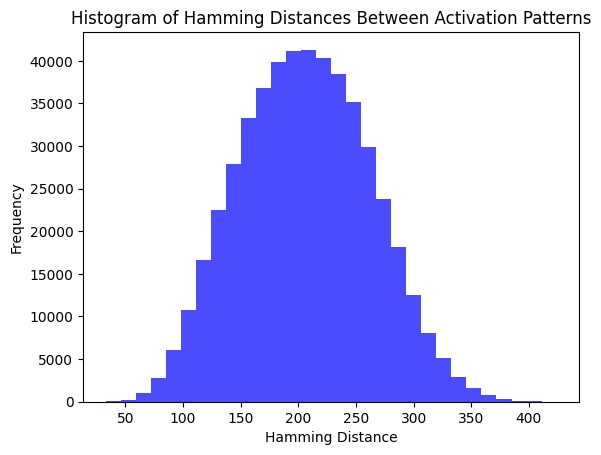

In [188]:
unique_patterns, counts, hamming_distances = analyze_activation_patterns(results_dict_spike['representations'][0:])

In [81]:
len(unique_patterns)

998

Number of unique activation patterns: 4968 out of (4968, 800)
Range of Hamming distances: 7.000000000000001 to 303.0


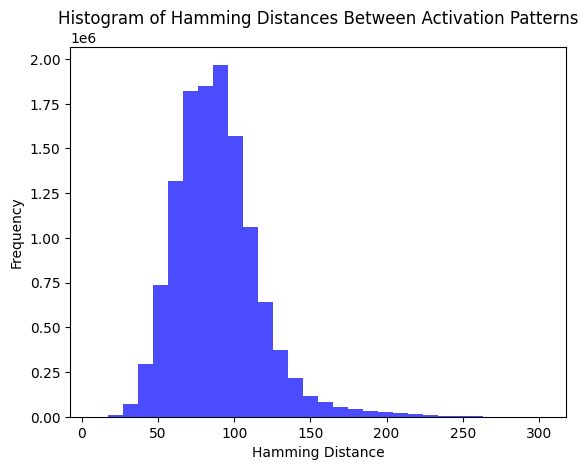

4968


In [82]:
results_dict_class = fixed_model_batch_analysis(model, torch.Tensor(mnist_data[class_data_indices]), train_labels[class_data_indices], device, '{}_{}'.format(anal_path, 'train_'), 'analyze', plotting=False)
unique_patterns, counts, hamming_distances = analyze_activation_patterns(results_dict_class['representations'][1:])
print(len(unique_patterns))

[array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0]]), array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]]), array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
   

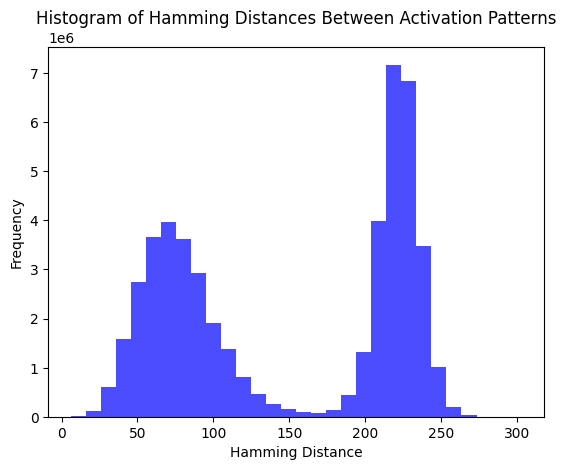

9900


In [34]:
class_data_indices = np.where(mnist_labels == 0)[0]
class_data_indices = np.concatenate([np.where(mnist_labels == 2)[0], class_data_indices])

results_dict_class = fixed_model_batch_analysis(model, torch.Tensor(mnist_data[class_data_indices]), train_labels[class_data_indices], device, '{}_{}'.format(anal_path, 'train_'), 'analyze', plotting=False)
unique_patterns, counts, hamming_distances = analyze_activation_patterns(results_dict_class['representations'][1:])
print(len(unique_patterns))

In [219]:
unique_patterns, counts, hamming_distances_flat = analyze_activation_patterns(results_dict['representations'][0:], 
                                                                              np.arange((results_dict['representations'][0].shape[0])) # type: ignore
                                                                              )

# Plot histogram of Hamming distances
plt.hist(hamming_distances_flat, bins=30, alpha=0.7, color='b')
plt.xlabel('Hamming Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Hamming Distances Between Activation Patterns')
plt.show()

Number of unique activation patterns: 50000 out of torch.Size([50000, 1584])


RuntimeError: CUDA error: invalid configuration argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Number of unique activation patterns: 10000 out of torch.Size([10000, 1584])


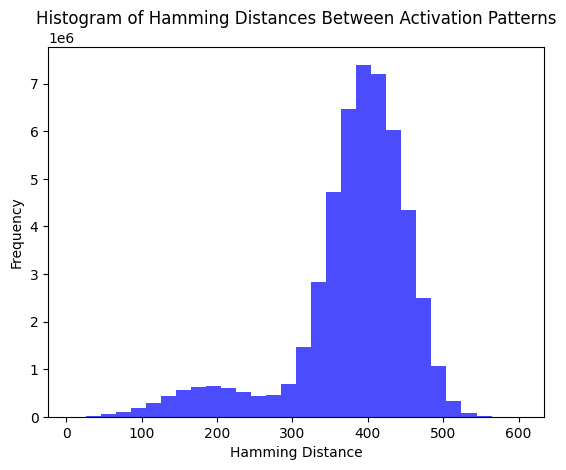

In [203]:
results_dict = fixed_model_batch_analysis(model, val_samples, val_labels, device, '{}_{}'.format(anal_path, 'train_'), 'analyze', plotting=False)
unique_patterns, counts, hamming_distances_flat = analyze_activation_patterns(results_dict['representations'][0:], 
                                                                              np.arange((results_dict['representations'][0].shape[0])) # type: ignore
                                                                              )

# Plot histogram of Hamming distances
plt.hist(hamming_distances_flat, bins=30, alpha=0.7, color='b')
plt.xlabel('Hamming Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Hamming Distances Between Activation Patterns')
plt.show()

In [19]:
def analyze_activation_patterns(relu_outputs, class_data_indices, device=torch.device("cuda")):
    # Convert ReLU output matrices into binary activation matrices
    binary_matrices = [(layer_output[class_data_indices].to(device) > 0).int() for layer_output in relu_outputs]

    # Concatenate all layer activations for each data point to form complete activation patterns
    activation_patterns = torch.cat(binary_matrices, dim=1)  # Shape: (num_data_points, total_neurons)

    # Find unique activation patterns and count them
    unique_patterns, counts = torch.unique(activation_patterns, dim=0, return_counts=True)
    num_unique_patterns = unique_patterns.size(0)
    # print(f"Number of unique activation patterns: {num_unique_patterns} out of {activation_patterns.shape}")

    # Calculate pairwise Hamming distances between all unique activation patterns
    hamming_distances = torch.cdist(unique_patterns.float(), unique_patterns.float(), p=0).cpu().numpy()
    hamming_distances_flat = hamming_distances[np.triu_indices(len(unique_patterns), k=1)]

    return unique_patterns, counts, hamming_distances_flat

def analyze_all_classes_and_spikes(model, mnist_data, mnist_labels, device, anal_path, results_dict, layer_idx=11):
    all_classes_hamming_distances = []
    all_spikes_hamming_distances = {}

    fig, axs = plt.subplots(10, 10, figsize=(35, 40))  # 10 classes, 1 class scatter + 1 class histogram + 8 spike histograms per row

    for class_idx in tqdm(range(10)):
        # Get the data for the current class
        class_data_indices = np.where(mnist_labels == class_idx)[0]
        # results_dict_class = fixed_model_batch_analysis(model, torch.Tensor(mnist_data[class_data_indices]), 
        #                                                 mnist_labels[class_data_indices], device, 
        #                                                 '{}_{}'.format(anal_path, 'train_'), 'analyze', plotting=False)

        relu_outputs_class = results_dict['representations']
        _, _, class_hamming_distances = analyze_activation_patterns(relu_outputs_class[0:], class_data_indices)
        all_classes_hamming_distances.append(class_hamming_distances)

        

        # Plot scatter plot for the class points and detected hyperplanes
        points = np.array(results_dict['pca_2'][layer_idx]).transpose()
        points = points[class_data_indices]

        axs[class_idx, 0].scatter(points[:, 0], points[:, 1], s=10, color='blue', alpha=0.5)
        detected_hyperplanes, total_error, assigned_points = spike_detection_nd(points)
        assignments, total_error, hyperplane_errors = assign_points_to_hyperplanes(points, detected_hyperplanes)

        colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
        for i in range(len(detected_hyperplanes)):
            axs[class_idx, 0].scatter(points[assignments == i, 0], points[assignments == i, 1], s=50, color=colors(i), alpha=0.5, label=f'Spike {i}')
        for coef, intercept, _, _ in detected_hyperplanes:
            xx = np.linspace(points[:, 0].min(), points[:, 0].max(), 100)
            yy = (-coef[0] * xx - intercept) / coef[1]
            axs[class_idx, 0].plot(xx, yy, color='gray', linestyle='--', alpha=0.5)
        axs[class_idx, 0].set_title(f'Class {class_idx} Scatter Plot with Hyperplanes')
        axs[class_idx, 0].set_xlabel('PCA Component 1')
        axs[class_idx, 0].set_ylabel('PCA Component 2')

        # Plot histogram for the class hamming distances
        # axs[class_idx, 1].hist(class_hamming_distances, bins=20, color='blue', alpha=0.7)
        axs[class_idx, 1].hist(class_hamming_distances, bins=50, color='blue', alpha=0.7, weights=np.ones(len(class_hamming_distances)) / len(class_hamming_distances) * 100)
        axs[class_idx, 1].set_title(f'Class {class_idx} Hamming Distances')
        axs[class_idx, 1].set_xlabel('Hamming Distance')
        axs[class_idx, 1].set_ylabel('Frequency (%)')

        # Fix x-axis and y-axis limits for class and spike histograms
        x_min, x_max = axs[0, 1].get_xlim()
        y_min, y_max = axs[0, 1].get_ylim()
        axs[class_idx, 1].set_xlim(x_min, x_max)
        axs[class_idx, 1].set_ylim(y_min, y_max)

        # Sort hyperplanes by the number of points assigned to them
        sorted_indices = np.argsort([np.sum(assignments == i) for i in range(len(detected_hyperplanes))])[::-1]
        detected_hyperplanes = [detected_hyperplanes[i] for i in sorted_indices]
        assignments = np.array([sorted_indices.tolist().index(a) for a in assignments])

        all_spikes_hamming_distances[class_idx] = []
        min_plots = 8

        for spike_idx in range(min(min_plots, len(detected_hyperplanes))):  # Plot up to 8 spikes per class
            # results_dict_spike = fixed_model_batch_analysis(model, torch.Tensor(mnist_data[class_data_indices][assignments == spike_idx]), 
            #                                                 mnist_labels[class_data_indices][assignments == spike_idx], device, 
            #                                                 '{}_{}'.format(anal_path, 'train_'), 'analyze', plotting=False)
            relu_outputs_spike = results_dict['representations']
            _, _, spike_hamming_distances = analyze_activation_patterns(relu_outputs_spike[0:], class_data_indices[assignments == spike_idx])
            all_spikes_hamming_distances[class_idx].append(spike_hamming_distances)

            # Plot histogram for the spike hamming distances
            # axs[class_idx, spike_idx + 2].hist(spike_hamming_distances, bins=20, color='red', alpha=0.7)
            axs[class_idx, spike_idx + 2].hist(spike_hamming_distances, bins=50, color='red', alpha=0.7, weights=np.ones(len(spike_hamming_distances)) / len(spike_hamming_distances) * 100)

            axs[class_idx, spike_idx + 2].set_title(f'Spike {spike_idx} Hamming Distances, #points: {class_data_indices[assignments == spike_idx].shape[0]}', fontsize=10)
            axs[class_idx, spike_idx + 2].set_xlabel('Hamming Distance')
            axs[class_idx, spike_idx + 2].set_ylabel('Frequency (%)')

            # Fix x-axis and y-axis limits for spike histograms
            axs[class_idx, spike_idx + 2].set_xlim(x_min, x_max)
            axs[class_idx, spike_idx + 2].set_ylim(y_min, y_max)

        # Remove unused axes in the row
        for spike_idx in range(len(detected_hyperplanes) + 2, min_plots + 2):
            fig.delaxes(axs[class_idx, spike_idx])

    plt.tight_layout()
    plt.savefig(f'{anal_path}/hamming_histogram_plot_layer{layer_idx}.png')

    return all_classes_hamming_distances, all_spikes_hamming_distances

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_3405676/4041033047.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:01<00:16,  1.83s/it]/tmp/ipykernel_3405676/4041033047.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:04<00:17,  2.13s/it]/tmp/ipykernel_3405676/4041033047.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

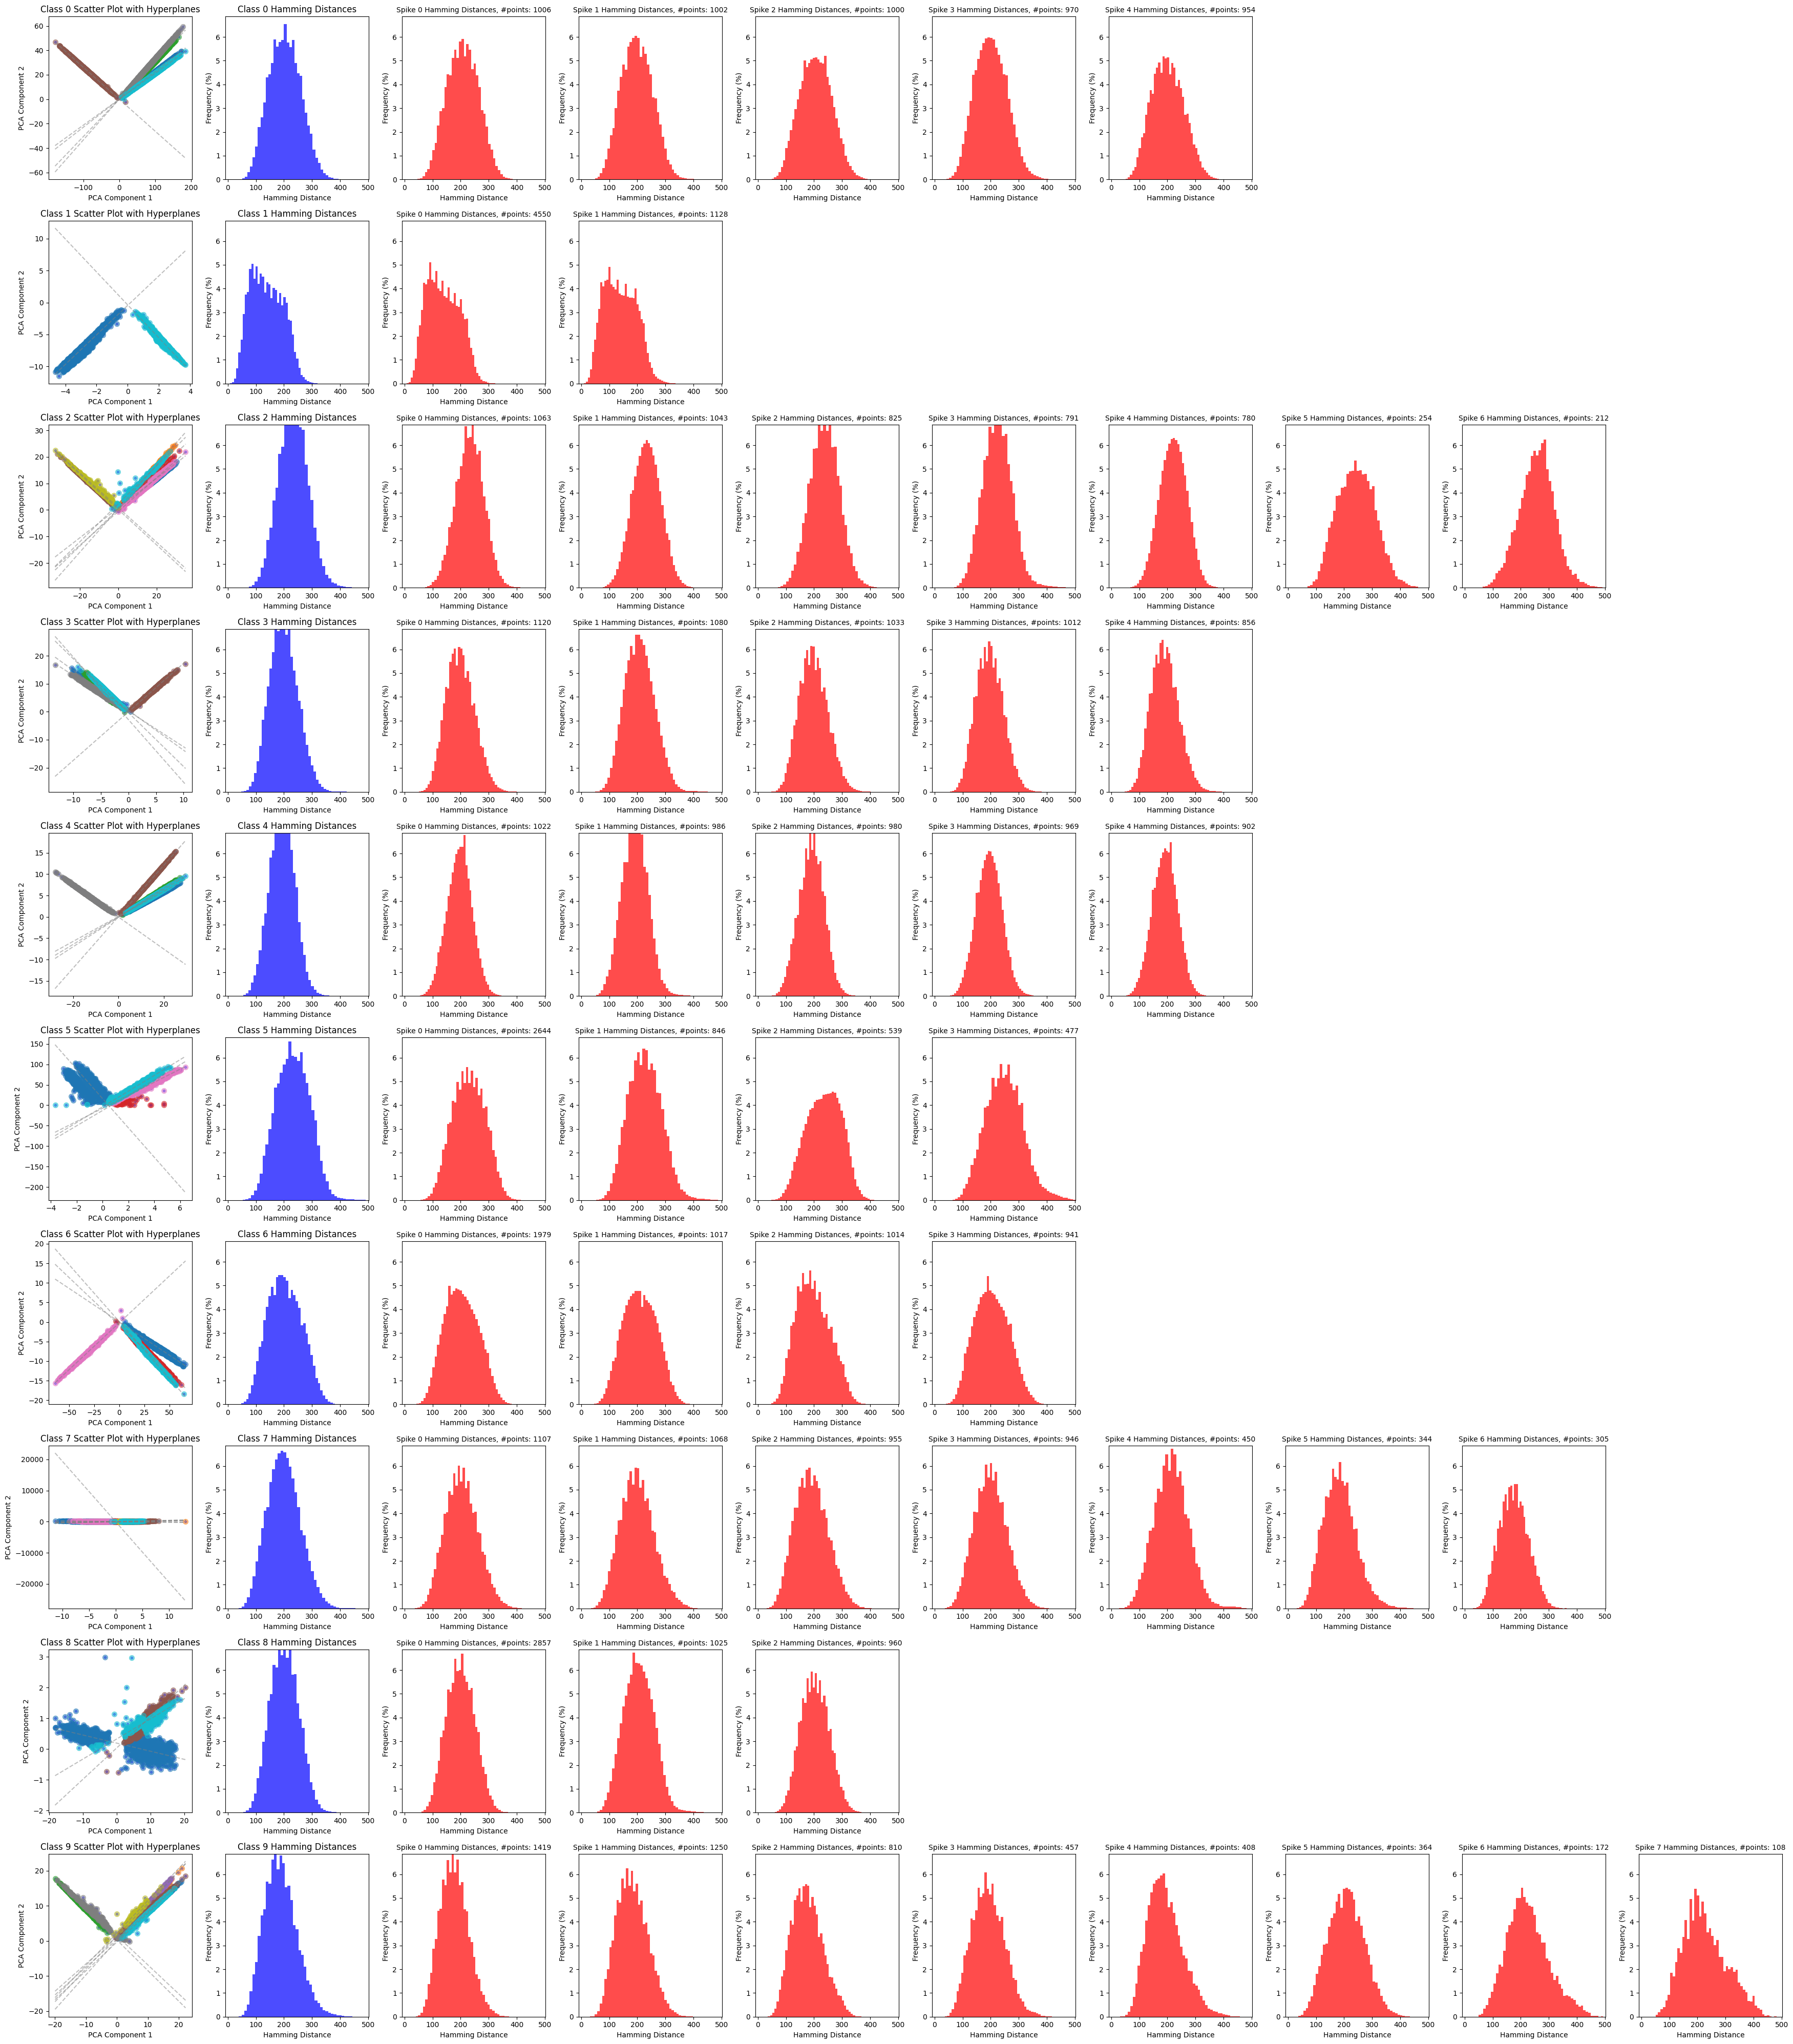

In [237]:
all_classes_hamming_distances, all_spikes_hamming_distances = analyze_all_classes_and_spikes(model, mnist_data, mnist_labels, device, anal_path, results_dict, layer_idx=10)

In [32]:
def analyze_all_layers(model, mnist_data, mnist_labels, device, anal_path, results_dict):
    # Iterate over layers
    for layer_idx in range(len(results_dict['representations'])):
        print(f"Analyzing Layer {layer_idx}...")
        layer_path = os.path.join(anal_path, f'layer_{layer_idx}')
        if not os.path.exists(layer_path):
            os.makedirs(layer_path)

        analyze_all_classes_and_spikes(
            model, mnist_data, mnist_labels, device, layer_path, results_dict, layer_idx=layer_idx
        )
        print(f"Layer {layer_idx} analysis saved in {layer_path}")


def analyze_all_classes_and_spikes(model, mnist_data, mnist_labels, device, anal_path, results_dict, layer_idx):
    all_classes_hamming_distances = []
    all_spikes_hamming_distances = {}

    fig, axs = plt.subplots(10, 10, figsize=(35, 40))  # 10 classes, 1 scatter + 1 class histogram + 8 spike histograms per row

    for class_idx in tqdm(range(10)):
        # Get the data for the current class
        class_data_indices = np.where(mnist_labels == class_idx)[0]

        relu_outputs_class = results_dict['representations']
        _, _, class_hamming_distances = analyze_activation_patterns(relu_outputs_class[:layer_idx + 1], class_data_indices)
        all_classes_hamming_distances.append(class_hamming_distances)

        # Plot scatter plot for the class points and detected hyperplanes
        points = np.array(results_dict['pca_2'][layer_idx]).transpose()
        points = points[class_data_indices]

        axs[class_idx, 0].scatter(points[:, 0], points[:, 1], s=10, color='blue', alpha=0.5)
        detected_hyperplanes, total_error, assigned_points = spike_detection_nd(points)
        assignments, total_error, hyperplane_errors = assign_points_to_hyperplanes(torch.Tensor(points), detected_hyperplanes)

        colors = plt.colormaps['tab10'](np.linspace(0, 1, len(detected_hyperplanes)))        
        for i in range(len(detected_hyperplanes)):
            axs[class_idx, 0].scatter(points[assignments == i, 0], points[assignments == i, 1], s=50, color=colors(i), alpha=0.5, label=f'Spike {i}')
        for coef, intercept, _, _ in detected_hyperplanes:
            xx = np.linspace(points[:, 0].min(), points[:, 0].max(), 100)
            yy = (-coef[0] * xx - intercept) / coef[1]
            axs[class_idx, 0].plot(xx, yy, color='gray', linestyle='--', alpha=0.5)
        axs[class_idx, 0].set_title(f'Class {class_idx} Scatter Plot with Hyperplanes')
        axs[class_idx, 0].set_xlabel('PCA Component 1')
        axs[class_idx, 0].set_ylabel('PCA Component 2')

        # Plot histogram for the class hamming distances
        axs[class_idx, 1].hist(class_hamming_distances, bins=50, color='blue', alpha=0.7, weights=np.ones(len(class_hamming_distances)) / len(class_hamming_distances) * 100)
        axs[class_idx, 1].set_title(f'Class {class_idx} Hamming Distances')
        axs[class_idx, 1].set_xlabel('Hamming Distance')
        axs[class_idx, 1].set_ylabel('Frequency (%)')

        # Fix x-axis and y-axis limits for class and spike histograms
        x_min, x_max = axs[0, 1].get_xlim()
        y_min, y_max = axs[0, 1].get_ylim()
        axs[class_idx, 1].set_xlim(x_min, x_max)
        axs[class_idx, 1].set_ylim(y_min, y_max)
        
        # Sort hyperplanes by the number of points assigned to them
        if torch.is_tensor(assignments):
            # Convert PyTorch tensor to NumPy array
            assignments_np = assignments.detach().cpu().numpy()
        else:
            assignments_np = assignments

        sorted_indices = np.argsort([np.sum(assignments_np == i) for i in range(len(detected_hyperplanes))])[::-1]
        detected_hyperplanes = [detected_hyperplanes[i] for i in sorted_indices]
        assignments = np.array([sorted_indices.tolist().index(a) for a in assignments_np])
        all_spikes_hamming_distances[class_idx] = []
        min_plots = 8

        for spike_idx in range(min(min_plots, len(detected_hyperplanes))):  # Plot up to 8 spikes per class
            relu_outputs_spike = results_dict['representations']
            _, _, spike_hamming_distances = analyze_activation_patterns(relu_outputs_spike[:layer_idx + 1], class_data_indices[assignments == spike_idx])
            all_spikes_hamming_distances[class_idx].append(spike_hamming_distances)

            axs[class_idx, spike_idx + 2].hist(spike_hamming_distances, bins=50, color='red', alpha=0.7, weights=np.ones(len(spike_hamming_distances)) / len(spike_hamming_distances) * 100)
            axs[class_idx, spike_idx + 2].set_title(f'Spike {spike_idx} Hamming Distances, #points: {class_data_indices[assignments == spike_idx].shape[0]}', fontsize=10)
            axs[class_idx, spike_idx + 2].set_xlabel('Hamming Distance')
            axs[class_idx, spike_idx + 2].set_ylabel('Frequency (%)')

            axs[class_idx, spike_idx + 2].set_xlim(x_min, x_max)
            axs[class_idx, spike_idx + 2].set_ylim(y_min, y_max)

        # Remove unused axes in the row
        for spike_idx in range(len(detected_hyperplanes) + 2, min_plots + 2):
            fig.delaxes(axs[class_idx, spike_idx])

    plt.tight_layout()
    plt.savefig(f'{anal_path}/hamming_histogram_plot_layer{layer_idx}.png')
    plt.close()

    return all_classes_hamming_distances, all_spikes_hamming_distances


SyntaxError: invalid syntax (2842021483.py, line 37)

In [33]:
analyze_all_layers(model, mnist_data, mnist_labels, device, anal_path, results_dict)

Analyzing Layer 0...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:08<01:19,  8.86s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:12<00:45,  5.71s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

Layer 0 analysis saved in ../../spike_analysis/spike_hamming_new2025_november/layer_0
Analyzing Layer 1...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:13<02:03, 13.75s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:26<01:46, 13.26s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

Layer 1 analysis saved in ../../spike_analysis/spike_hamming_new2025_november/layer_1
Analyzing Layer 2...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:13<02:04, 13.88s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:27<01:49, 13.72s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

Layer 2 analysis saved in ../../spike_analysis/spike_hamming_new2025_november/layer_2
Analyzing Layer 3...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:13<02:05, 13.96s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:27<01:51, 13.99s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

Layer 3 analysis saved in ../../spike_analysis/spike_hamming_new2025_november/layer_3
Analyzing Layer 4...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:14<02:07, 14.13s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:28<01:52, 14.10s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

Layer 4 analysis saved in ../../spike_analysis/spike_hamming_new2025_november/layer_4
Analyzing Layer 5...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:13<02:00, 13.44s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:27<01:51, 13.93s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

Layer 5 analysis saved in ../../spike_analysis/spike_hamming_new2025_november/layer_5
Analyzing Layer 6...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:13<02:05, 13.89s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:15<00:52,  6.59s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

Layer 6 analysis saved in ../../spike_analysis/spike_hamming_new2025_november/layer_6
Analyzing Layer 7...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:08<01:16,  8.45s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:10<00:39,  4.97s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

Layer 7 analysis saved in ../../spike_analysis/spike_hamming_new2025_november/layer_7
Analyzing Layer 8...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:13<02:05, 13.95s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:15<00:52,  6.60s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

Layer 8 analysis saved in ../../spike_analysis/spike_hamming_new2025_november/layer_8
Analyzing Layer 9...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:11<01:45, 11.76s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:13<00:46,  5.83s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

Layer 9 analysis saved in ../../spike_analysis/spike_hamming_new2025_november/layer_9
Analyzing Layer 10...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:01<00:15,  1.72s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:03<00:12,  1.60s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

Layer 10 analysis saved in ../../spike_analysis/spike_hamming_new2025_november/layer_10
Analyzing Layer 11...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 10%|█         | 1/10 [00:01<00:10,  1.20s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(detected_hyperplanes))
 20%|██        | 2/10 [00:02<00:11,  1.40s/it]/tmp/ipykernel_1398895/1159927999.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.color

Layer 11 analysis saved in ../../spike_analysis/spike_hamming_new2025_november/layer_11


In [217]:
def plot_hamming_distance_boxplot(all_classes_hamming_distances, all_spikes_hamming_distances):
    fig, axs = plt.subplots(10, 9, figsize=(30, 40))  # 10 classes, 1 class boxplot + 8 spike boxplots per row

    for class_idx, class_hamming_distances in enumerate(all_classes_hamming_distances):
        # Plot boxplot for the class hamming distances
        class_box = axs[class_idx, 0].boxplot(class_hamming_distances, patch_artist=True)
        axs[class_idx, 0].set_title(f'Class {class_idx} Hamming Distances')
        axs[class_idx, 0].set_xlabel('Class')
        axs[class_idx, 0].set_ylabel('Hamming Distance')

        # Get the mean value of the class hamming distances
        class_mean = np.mean(class_hamming_distances)

        # Fix x-axis and y-axis limits for class and spike boxplots
        y_min, y_max = axs[class_idx, 0].get_ylim()

        # Add spike hamming distances for the current class
        for spike_idx, spike_hamming_distances in enumerate(all_spikes_hamming_distances[class_idx]):
            axs[class_idx, spike_idx + 1].boxplot(spike_hamming_distances, patch_artist=True)
            axs[class_idx, spike_idx + 1].set_title(f'Class {class_idx} Spike {spike_idx} Hamming Distances')
            axs[class_idx, spike_idx + 1].set_xlabel('Spike')
            axs[class_idx, spike_idx + 1].set_ylabel('Hamming Distance')

            # Set y-axis limits to match the class boxplot
            axs[class_idx, spike_idx + 1].set_ylim(y_min, y_max)

            # Draw a dashed gray line for the class mean
            axs[class_idx, spike_idx + 1].axhline(class_mean, color='gray', linestyle='--')

        # Remove unused axes in the row
        for spike_idx in range(len(all_spikes_hamming_distances[class_idx]) + 1, 9):
            fig.delaxes(axs[class_idx, spike_idx])

    plt.tight_layout()
    plt.savefig(f'{anal_path}/hamming_boxplot_plot.png')


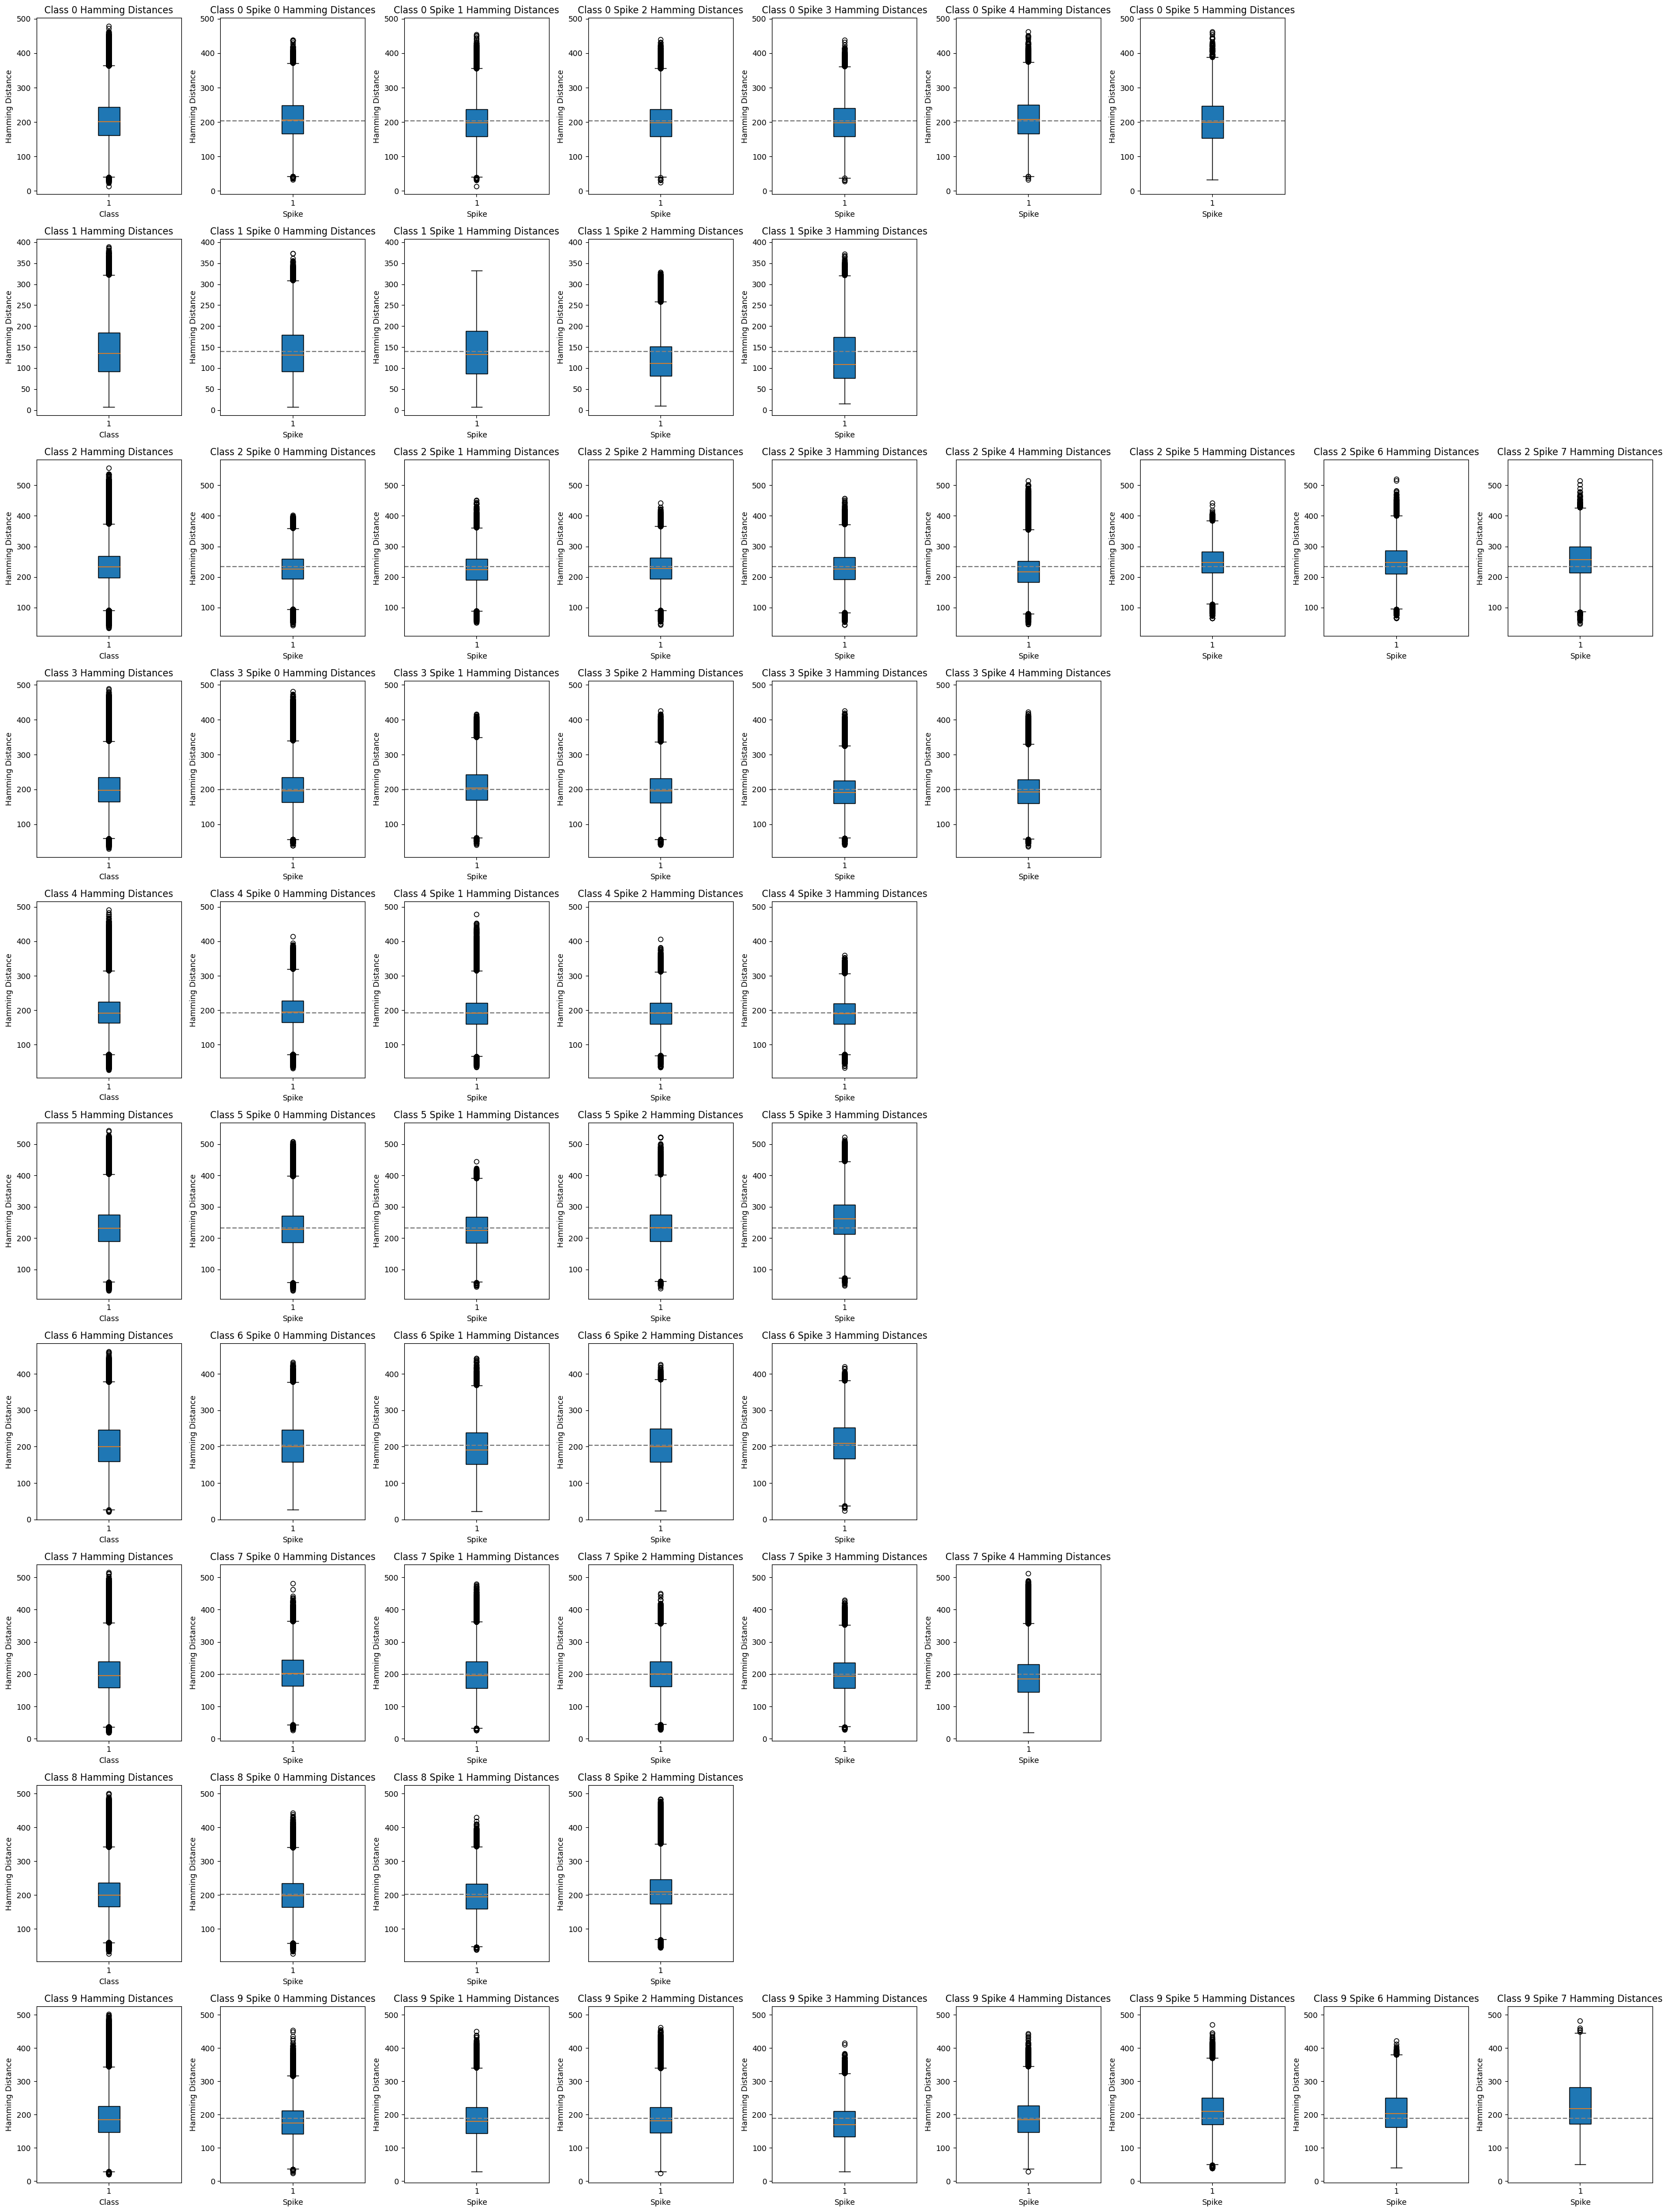

In [218]:
plot_hamming_distance_boxplot(all_classes_hamming_distances, all_spikes_hamming_distances)